# LLM - Bielik - Fine tuning - part I

## Motivation

The rise and investments of the Large Language Models are definetely a game changer on various markets and branches - we can observe increased popularity of LLMs in academia, business and agriculture etc. Working with LLMs became a must-do task for all R&D or business departments in order to acknowledge and adapt upcoming possibilities, to stay competetive and gain business advantage. There are many players who invested bilions of USD to build their own Large Language Model and took a part in recent markets challenges by introducing their own solution trained on a different data set or to serve a different task (specialized for example in generation of poems or making a summary). At the beginning, as usual when it comes to innovation at that scale, we are thinking of endless possibilities, what kind of new opportunities we reach without putting much focus on other important factors like costs, maintanence, security, stability. Currently, we have multiple models which are production ready - many work has been done at those fields also making those LLMs more reliable and secured. One of the outcomes from this LLM race is that people noticed that it is good idea to look at smaller models, more specialized in one or two tasks, not the general ones. This specialization also is related to language supported. LLMs are broadly trained on english language data, due to the fact that more than half of websites content is written in English (source). Many models, paid and open source ones, have different level of quality when it comes when using them with local language. Quite often it occurs that offered quality is not enough to prove the business value for specific use case. This pushed some parties to create smaller models or suggested the finetuning with data in local language. 

The goal of this notebook is to finetune a Polish language based LLM called Bielik, developed by SpeakLeash organization (<model page>) with the legal / law sources. Data is specifically chosen for this task - legal documents or, law as a general concept, are strictly connected to the particular langauge. Primary concept of legal documents is to be in line with local (polish in my case) regulations. Of course, those documents can be translated to english and then used by the LLM. However, legal documents such as purchase agreements or any other agreements are designed by lawyers who understand the legal language nuances. They need to construct documents that are reliable, understandable by many (or maybe not?) and embedded in Polish law regulations. This requires from LLM to be more specific on many levels - starting from using prevalent data in one language and finetuning it to be able to work with more detailed task. 

## Introduction

This notebook covers multiple steps:
1. Loading and splitting data
2. Generating new data (question and answers) for the future finetuning
3. Evaluating generated data


## Loading and splitting data

1. Data source: https://isap.sejm.gov.pl/isap.nsf/download.xsp/WDU20140000827/U/D20140827Lj.pdf 
2. 

In [21]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv, find_dotenv
import pymupdf
import uuid
from pprint import pprint
from tqdm.notebook import tqdm
from gensim.models import KeyedVectors
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
_ = load_dotenv(find_dotenv())

In [1]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=120)

In [2]:
path = 'data/ustawa_nr_1.pdf'

all_data = pymupdf.open(path)

In [3]:
all_chunks = []
for document in all_data:
    text_page = document.get_textpage().extractText()
    chunks_per_page = splitter.split_text(text_page)
    all_chunks.append(chunks_per_page)
        
len(all_chunks)

44

In [4]:
all_chunks[43]

['©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n \n2024-01-18 \n \nZałącznik nr 2 \n \nWZÓR FORMULARZA ODSTĄPIENIA OD UMOWY \n \n(formularz ten należy wypełnić i odesłać tylko w przypadku chęci odstąpienia od umowy) \n– Adresat [w tym miejscu przedsiębiorca powinien wpisać nazwę przedsiębiorcy, pełny adres pocztowy oraz adres e-mail] \n– Ja/My(*) niniejszym informuję/informujemy(*) o moim/naszym odstąpieniu od umowy sprzedaży następujących  towarów(*)',
 'umowy dostawy następujących  towarów(*) umowy o dzieło polegającej na wykonaniu następujących towarów(*)/o \nświadczenie następującej usługi(*) \n– Data zawarcia umowy(*)/odbioru(*) \n– Imię i nazwisko konsumenta(-ów) \n– Adres konsumenta(-ów) \n– Podpis konsumenta(-ów) (tylko jeżeli formularz jest przesyłany w wersji papierowej) \n– Data \n \n \n \n \n(*) Niepotrzebne skreślić.']

In [5]:
pprint(all_chunks[0][6])

('z 22.05.2019, str. 28 oraz Dz. Urz. UE L 305 z 26.11.2019, str. 63). \n'
 'Opracowano na \n'
 'podstawie: \n'
 't.j. \n'
 'Dz. U. z 2023 r. \n'
 'poz. 2759.')


In [6]:
all = []
for i, page in tqdm(enumerate(all_chunks)):
    page_id = str(uuid.uuid4())
    for chunk in enumerate(page):
        nth_chunk, text_chunk = chunk
        generated_questions = ask_gpt(chunk)
        data = {'chunk_id': f'{page_id}_{nth_chunk}', 
                'text_chunk': text_chunk,
                'page_id': page_id,
                'generated_questions': generated_questions}
        all.append(data)

0it [00:00, ?it/s]

NameError: name 'ask_gpt' is not defined

In [57]:
df = pd.DataFrame.from_dict(data=all)
df

,chunk_id,text_chunk,page_id,generated_questions
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...
1,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie są zasady i tryb wykonania prawa odstą...
2,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_2,1) dyrektywę Parlamentu Europejskiego i Rady 2...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie konkretnie prawa konsumentów reguluje ...
3,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_3,"str. 64, z późn. zm.), ostatnio zmienioną dyre...",a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie zmiany wprowadziła dyrektywa Parlament...
4,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_4,90/619/EWG oraz dyrektywy 97/7/WE i 98/27/WE (...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie są główne dyrektywy Unii Europejskiej ...
...,...,...,...,...
246,c38a3854-eb6b-41cd-b18c-22ff37a56130_5,"– Jeżeli, w przypadku umów zawieranych poza lo...",c38a3854-eb6b-41cd-b18c-22ff37a56130,"- Czy istnieją określone warunki, które muszą ..."
247,c38a3854-eb6b-41cd-b18c-22ff37a56130_6,inny niż było to konieczne do stwierdzenia cha...,c38a3854-eb6b-41cd-b18c-22ff37a56130,- Czy istnieją określone przepisy dotyczące st...
248,c38a3854-eb6b-41cd-b18c-22ff37a56130_7,cieplnej [niepotrzebne skreślić] przed upływem...,c38a3854-eb6b-41cd-b18c-22ff37a56130,"- Jakie są konsekwencje dla klienta, jeśli zde..."
249,3013532f-7032-49d0-839d-2093d1d4a2fe_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy formularz odstąpienia od umowy musi być ...


In [59]:
# Saving checkpoint
df.to_excel('data/questions_and_chunks.xlsx')

In [14]:
df = pd.read_excel('data/questions_and_chunks.xlsx', index_col=0)

In [15]:
df

,chunk_id,text_chunk,page_id,generated_questions
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...
1,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie są zasady i tryb wykonania prawa odstą...
2,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_2,1) dyrektywę Parlamentu Europejskiego i Rady 2...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie konkretnie prawa konsumentów reguluje ...
3,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_3,"str. 64, z późn. zm.), ostatnio zmienioną dyre...",a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie zmiany wprowadziła dyrektywa Parlament...
4,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_4,90/619/EWG oraz dyrektywy 97/7/WE i 98/27/WE (...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie są główne dyrektywy Unii Europejskiej ...
...,...,...,...,...
246,c38a3854-eb6b-41cd-b18c-22ff37a56130_5,"– Jeżeli, w przypadku umów zawieranych poza lo...",c38a3854-eb6b-41cd-b18c-22ff37a56130,"- Czy istnieją określone warunki, które muszą ..."
247,c38a3854-eb6b-41cd-b18c-22ff37a56130_6,inny niż było to konieczne do stwierdzenia cha...,c38a3854-eb6b-41cd-b18c-22ff37a56130,- Czy istnieją określone przepisy dotyczące st...
248,c38a3854-eb6b-41cd-b18c-22ff37a56130_7,cieplnej [niepotrzebne skreślić] przed upływem...,c38a3854-eb6b-41cd-b18c-22ff37a56130,"- Jakie są konsekwencje dla klienta, jeśli zde..."
249,3013532f-7032-49d0-839d-2093d1d4a2fe_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy formularz odstąpienia od umowy musi być ...


In [19]:
df['generated_questions_array'] = df['generated_questions'].str.split('\n')

In [37]:
df.shape

(753, 5)

In [24]:
df = df.explode('generated_questions_array')
df

,chunk_id,text_chunk,page_id,generated_questions,generated_questions_array
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie prawa określa ustawa z dnia 30 maja 20...
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie obowiązki ma przedsiębiorca zawierając...
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,
0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- W jaki sposób regulowane są zasady i tryb za...
...,...,...,...,...,...
249,3013532f-7032-49d0-839d-2093d1d4a2fe_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy formularz odstąpienia od umowy musi być ...,
249,3013532f-7032-49d0-839d-2093d1d4a2fe_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy formularz odstąpienia od umowy musi być ...,"- Czy istnieją okoliczności, w których odstąpi..."
250,3013532f-7032-49d0-839d-2093d1d4a2fe_1,umowy dostawy następujących towarów(*) umowy ...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy umowy dostawy towarów i umowy o dzieło s...,- Czy umowy dostawy towarów i umowy o dzieło s...
250,3013532f-7032-49d0-839d-2093d1d4a2fe_1,umowy dostawy następujących towarów(*) umowy ...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy umowy dostawy towarów i umowy o dzieło s...,- Jakie są konsekwencje prawne braku podpisu k...


In [36]:
df = df[~df['generated_questions_array'].isna()]
df.shape

(753, 5)

In [35]:


df['generated_questions_array']  = df['generated_questions_array'].replace(r'^\s*$', np.nan, regex=True)

In [47]:
df['answer'] = df.apply(lambda x: complex_ask_gpt(x['text_chunk'], x['generated_questions_array']), axis=1)

In [53]:
df.to_excel('data/data_with_answers.xlsx')

In [58]:
df['coverage_rating'] = df.apply(lambda x: get_covarage_by_gpt(question=x['generated_questions_array'], context=x['text_chunk']), axis=1)

NameError: name 'new_data' is not defined

In [67]:
df['coverage_rating_no_answer'].value_counts()

coverage_rating_no_answer
5    707
4     37
1      6
2      2
3      1
Name: count, dtype: int64

In [63]:
df.to_excel('data/data_with_answers_and_cov.xlsx')

In [4]:
df = pd.read_excel('data/data_without_stopdwords.xlsx')

In [72]:
with open('utils/polish.stopwords.txt') as file:
    stopwords = file.readlines()

stopwords = [word.replace('\n', '') for word in stopwords]


def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stopwords]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala', 'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna', 'jednak', 'jednakze', 'jednakże', 'jedno'

In [74]:
df_2 = df.copy(deep=True)

In [79]:
df['text_wo_stopwords'] = df['text_chunk'].apply(preprocess)

In [81]:
df['question_wo_stopwords'] = df['generated_questions_array'].apply(preprocess)

In [83]:
df.to_excel('data/data_without_stopdwords.xlsx')

In [8]:
model = KeyedVectors.load("models/word2vec/word2vec_100_3_polish.bin")

In [9]:
def get_diversity_by_wmd(question: str, context: str):
    wmd = model.wmdistance(question, context)
    return wmd

In [13]:
df = pd.read_excel('data/data_without_stopdwords.xlsx', index_col=0)

In [27]:
def clean_text(x):
    text = x.replace('\n', '')
    return text

In [29]:
df['chunk'] = df['text_chunk'].apply(lambda x: clean_text(x))

In [52]:
df['wmd_question_answer'] = df.apply(lambda x: get_diversity_by_wmd(x['generated_questions_array'], x['answer']), axis=1)

In [49]:
df[df['wmd'] > 0.93]['generated_questions_array']

5    - W j
Name: generated_questions_array, dtype: object

<Axes: >

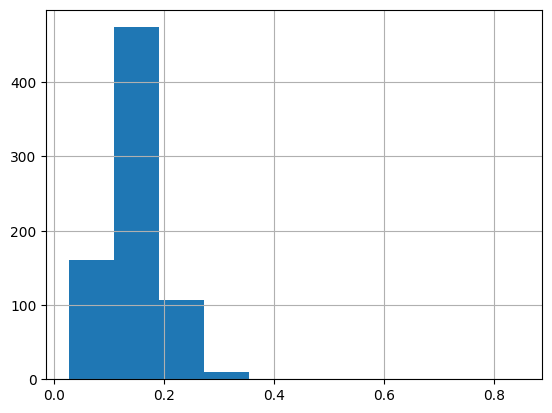

In [53]:
pd.plotting.hist_series(df['wmd_question_answer'])

<Axes: >

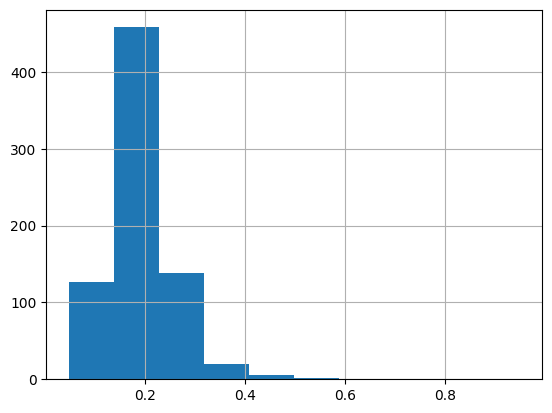

In [54]:
pd.plotting.hist_series(df['wmd'])

In [ ]:
# MIN DISTANCE
# QUESTION
# - Jakie są konsekwencje korzystania z towaru w sposób wykraczający poza konieczny do stwierdzenia jego charakteru, cech i funkcjonowania, gdy przedsiębiorca nie poinformował konsumenta o prawie odstąpienia od umowy zgodnie z wymaganiami art. 12 ust. 1 pkt 9?

# CHUNK
# wynikiem korzystania z niego w sposób wykraczający poza konieczny do \nstwierdzenia charakteru, cech i funkcjonowania towaru, chyba że przedsiębiorca nie \npoinformował konsumenta o prawie odstąpienia od umowy zgodnie z wymaganiami \nart. 12 ust. 1 pkt 9.

In [ ]:
# MAX DISTANCE
# CHUNK
# niektórych aspektów umów o dostarczanie treści cyfrowych i usług cyfrowych (Dz. Urz. \nUE L 136 z 22.05.2019, str. 1 oraz Dz. Urz. UE L 305 z 26.11.2019, str. 60); \n4) dyrektywę Parlamentu Europejskiego i Rady (UE) 2019/771 z dnia 20 maja 2019 r. w sprawie \nniektórych aspektów umów sprzedaży towarów, zmieniającą rozporządzenie (UE) 2017/2394 \noraz dyrektywę 2009/22/WE i uchylającą dyrektywę 1999/44/WE (Dz. Urz. UE L 136 \nz 22.05.2019, str. 28 oraz Dz. Urz. UE L 305 z 26.11.2019, str. 63).

# - W j

In [63]:
sample_df = df.sample(3)

In [96]:
df['coherence'] = df['generated_questions_array'].apply(lambda x: get_coherence(x))

In [98]:
df.to_excel('data/with_coherence.xlsx')

In [111]:
df = pd.read_excel('data/with_coherence.xlsx')

In [113]:
df[['coherence_rate', 'coherence_expl']] = df.coherence.str.split(',', n=1,  expand=True)

In [114]:
df['coherence_rate'] = df.coherence_rate.str.replace('(', '')
df['coherence_expl'] = df.coherence_expl.str.replace(')', '')
df['coherence_expl'] = df.coherence_expl.str.replace('"', '')
df

,Unnamed: 0,chunk_id,text_chunk,page_id,generated_questions,generated_questions_array,answer,coverage_rating,coverage_rating_no_answer,text_wo_stopwords,question_wo_stopwords,chunk,wmd,wmd_question_answer,coherence,coherence_rate,coherence_expl
0,0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie prawa określa ustawa z dnia 30 maja 20...,Ustawa z dnia 30 maja 2014 r. o prawach konsum...,5,5,"['©kancelaria', 'sejmu', 's.', '1/44', '2024-0...","['-', 'prawa', 'określa', 'ustawa', 'dnia', '3...",©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.301395,0.341273,"(3, ""The question is coherent as it clearly as...",3,The question is coherent as it clearly asks a...
1,0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie obowiązki ma przedsiębiorca zawierając...,"Zgodnie z art. 1 ustawy o prawach konsumenta, ...",5,5,"['©kancelaria', 'sejmu', 's.', '1/44', '2024-0...","['-', 'obowiązki', 'przedsiębiorca', 'zawieraj...",©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.209397,0.139826,"(3, The question is coherent in terms of askin...",3,The question is coherent in terms of asking a...
2,0,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie prawa określa ustawa z dnia 30 maja 20...,- W jaki sposób regulowane są zasady i tryb za...,Zasady i tryb zawierania umowy na odległość i ...,5,5,"['©kancelaria', 'sejmu', 's.', '1/44', '2024-0...","['-', 'regulowane', 'zasady', 'tryb', 'zawiera...",©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.216716,0.122686,"(4, ""The question is coherent and fluent, but ...",4,"The question is coherent and fluent, but coul..."
3,1,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie są zasady i tryb wykonania prawa odstą...,- Jakie są zasady i tryb wykonania prawa odstą...,Zasady i tryb wykonania prawa odstąpienia od u...,5,5,"['przedsiębiorstwa;', '3)', 'zasady', 'tryb', ...","['-', 'zasady', 'tryb', 'wykonania', 'prawa', ...",przedsiębiorstwa; 3) zasady i tryb wykonania p...,0.153880,0.112443,"(4, The question is coherent and fluent as it ...",4,The question is coherent and fluent as it cle...
4,1,a85d0bcd-8bd8-4f01-8a12-afd186aa2381_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,a85d0bcd-8bd8-4f01-8a12-afd186aa2381,- Jakie są zasady i tryb wykonania prawa odstą...,- W jaki sposób regulacje dotyczące umowy na o...,Umowa na odległość dotycząca usług finansowych...,5,5,"['przedsiębiorstwa;', '3)', 'zasady', 'tryb', ...","['-', 'regulacje', 'dotyczące', 'umowy', 'odle...",przedsiębiorstwa; 3) zasady i tryb wykonania p...,0.284043,0.264828,"(4, ""The question is coherent and clear, but c...",4,"The question is coherent and clear, but could..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,249,3013532f-7032-49d0-839d-2093d1d4a2fe_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy formularz odstąpienia od umowy musi być ...,"- Jakie są konsekwencje prawne dla konsumenta,...",Jeśli konsument nie zastosuje się do procedury...,5,5,"['©kancelaria', 'sejmu', 's.', '44/44', '2024-...","['-', 'konsekwencje', 'prawne', 'konsumenta,',...",©Kancelaria Sejmu s. 44/44 2024-01-18 Z...,0.232825,0.137973,"(4, ""The question is coherent and clear, but c...",4,"The question is coherent and clear, but could..."
749,249,3013532f-7032-49d0-839d-2093d1d4a2fe_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,3013532f-7032-49d0-839d-2093d1d4a2fe,- Czy formularz odstąpienia od umowy musi być ...,"- Czy istnieją okoliczności, w których odstąpi...","Tak, istnieją okoliczności, w których odstąpie...",5,5,"['©kancelaria', 'sejmu', 's.', '44/44', '2024-...

In [ ]:
df.to_excel('data/latest.xlsx', index = False)

In [19]:
df = pd.read_excel('data/latest.xlsx')

In [6]:
sample_df = df.sample(15)

In [20]:
similarities = {}
for index2, row2 in tqdm(df.iterrows()):
    for index1, row1 in df.iterrows():
        sim_score = get_diversity_by_wmd(row2['generated_questions_array'], row1['generated_questions_array'])
        q1 = row2['generated_questions_array']
        q2 = row1['generated_questions_array']
        questions = f'{q1} | {q2}'
        similarities[questions] = {'wmd_qq': sim_score}

In [22]:
sim_df = pd.DataFrame.from_dict(similarities)

In [23]:
results = sim_df.T.reset_index().rename(columns={'index': 'question'})
results[['question', 'compared_to_question']] = results['question'].str.split('|', expand=True)
results
#results = results.drop(['question'], axis=1)
# results = results[['question', 'compared_to_question', 'wmd_qq']]

,question,wmd_qq,compared_to_question
0,- Jakie prawa określa ustawa z dnia 30 maja 20...,0.000000,- Jakie prawa określa ustawa z dnia 30 maja 2...
1,- Jakie prawa określa ustawa z dnia 30 maja 20...,0.373892,- Jakie obowiązki ma przedsiębiorca zawierają...
2,- Jakie prawa określa ustawa z dnia 30 maja 20...,0.341291,- W jaki sposób regulowane są zasady i tryb z...
3,- Jakie prawa określa ustawa z dnia 30 maja 20...,0.363281,- Jakie są zasady i tryb wykonania prawa odst...
4,- Jakie prawa określa ustawa z dnia 30 maja 20...,0.490976,- W jaki sposób regulacje dotyczące umowy na ...
...,...,...,...
565499,- Czy istnieją szczególne wymagania co do daty...,0.134491,- Jakie są konsekwencje prawne dla konsumenta...
565500,- Czy istnieją szczególne wymagania co do daty...,0.205283,"- Czy istnieją okoliczności, w których odstąp..."
565501,- Czy istnieją szczególne wymagania co do daty...,0.182021,- Czy umowy dostawy towarów i umowy o dzieło ...
565502,- Czy istnieją szczególne wymagania co do daty...,0.235739,- Jakie są konsekwencje prawne braku podpisu ...


In [24]:

import seaborn as sns
sim_heatmap = results.pivot(index='question', columns='compared_to_question', values='wmd_qq')
mask = np.zeros_like(sim_heatmap)
mask[np.triu_indices_from(mask)] = True

# sns.heatmap(sim_heatmap,
#             annot=True,
#             fmt='.2f',
#             linewidth=.5,
#             cmap='crest',
#             mask=mask,
#             annot_kws={'fontsize': 8})